In [1]:
import os
import json

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# Using the GPU (cuda)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [16]:
# Task 1 - Load the FashionMNIST dataset, split to parts
# Testing 50k, validation 10k, testing 10k

# It's to normalize the data with std and mean of 0.5
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=10),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 60k images
full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# 10k images
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


# Split the training data to training and validation - 50k and 10k
training_data, validation_data = torch.utils.data.random_split(
    full_training_data,
    [50000, 10000]
)

print(f"Training data size: {len(training_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Testing data size: {len(testing_data)}")


Training data size: 50000
Validation data size: 10000
Testing data size: 10000


In [4]:
# Task 2 - Create LeNet-5 model architecture as baseline
# Input grayscale image of size 28x28x1 and has 10 outputs, one for each class
# Assume no-zero padding was applied
# Trained using cross-entropy loss, Adam optimizer and learning rate of 0.001

# LeNet-5 model baseline
class LeNet5_Baseline(torch.nn.Module):
    def __init__(self):
        super(LeNet5_Baseline, self).__init__()
        # 6 filters of size 5x5
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.activation1 = torch.nn.Sigmoid()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 16 filters of size 5x5
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.activation2 = torch.nn.Sigmoid()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        # 16*4*4 is the size of the output of the second convolutional layer
        self.fc1 = torch.nn.Linear(16*4*4, 120)
        self.activation3 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(120, 84)
        self.activation4 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='sigmoid')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # The flow of the model
    # In original LeNet-5 they used sigmoid activation function
    # In lecture it uses ReLU and since we want kaiming_uniform we use ReLU
    # Also since we use cross-entropy loss we don't need to use softmax
    def forward(self, x):
        x = self.pool1(self.activation1(self.conv1(x)))
        x = self.pool2(self.activation2(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)

        return x

In [52]:
# Task 3 - Create four model variants

# LeNet-5 model v2 - From SIGMOID TO RELU
class LeNet5_v2(torch.nn.Module):
    def __init__(self):
        super(LeNet5_v2, self).__init__()
        # 6 filters of size 5x5
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.activation1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 16 filters of size 5x5
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.activation2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        # 16*4*4 is the size of the output of the second convolutional layer
        self.fc1 = torch.nn.Linear(16*4*4, 120)
        self.activation3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(120, 84)
        self.activation4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # The flow of the model
    # In original LeNet-5 they used sigmoid activation function
    # In lecture it uses ReLU and since we want kaiming_uniform we use ReLU
    # Also since we use cross-entropy loss we don't need to use softmax
    def forward(self, x):
        x = self.pool1(self.activation1(self.conv1(x)))
        x = self.pool2(self.activation2(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)

        return x
    
# LeNet-5 model v3 - Same as v2 but with adaptive learning rate
class LeNet5_v3(torch.nn.Module):
    def __init__(self):
        super(LeNet5_v3, self).__init__()
        # 6 filters of size 5x5
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.activation1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 16 filters of size 5x5
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.activation2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        # 16*4*4 is the size of the output of the second convolutional layer
        self.fc1 = torch.nn.Linear(16*4*4, 120)
        self.activation3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(120, 84)
        self.activation4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # The flow of the model
    # In original LeNet-5 they used sigmoid activation function
    # In lecture it uses ReLU and since we want kaiming_uniform we use ReLU
    # Also since we use cross-entropy loss we don't need to use softmax
    def forward(self, x):
        x = self.pool1(self.activation1(self.conv1(x)))
        x = self.pool2(self.activation2(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)

        return x

# LeNet-5 model v4 - Fully connected layer from 120 to 240
class LeNet5_v4(torch.nn.Module):
    def __init__(self):
        super(LeNet5_v4, self).__init__()
        # 6 filters of size 5x5
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.activation1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 16 filters of size 5x5
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.activation2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        # 16*3*3 is the size of the output of the second convolutional layer
        self.fc1 = torch.nn.Linear(16*4*4, 120)
        self.activation3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(120, 84)
        self.activation4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # The flow of the model
    # In original LeNet-5 they used sigmoid activation function
    # In lecture it uses ReLU and since we want kaiming_uniform we use ReLU
    # Also since we use cross-entropy loss we don't need to use softmax
    def forward(self, x):
        x = self.pool1(self.activation1(self.conv1(x)))
        x = self.pool2(self.activation2(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)

        return x

 # LeNet-5 model v5 - More neurons on the first fully connected layer from 120 to 240
class LeNet5_v5(torch.nn.Module):
    def __init__(self):
        super(LeNet5_v5, self).__init__()
        # 6 filters of size 9x9
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=9)
        self.activation1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 16 filters of size 5x5
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.activation2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 32 filters of size 5x5
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=5)
        self.activation3 = torch.nn.ReLU()
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        # 16*4*4 is the size of the output of the second convolutional layer
        self.fc1 = torch.nn.Linear(32*4*4, 120)
        self.activation3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(120, 84)
        self.activation4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # The flow of the model
    # In original LeNet-5 they used sigmoid activation function
    # In lecture it uses ReLU and since we want kaiming_uniform we use ReLU
    # Also since we use cross-entropy loss we don't need to use softmax
    def forward(self, x):
        x = self.pool1(self.activation1(self.conv1(x)))
        x = self.pool2(self.activation2(self.conv2(x)))
        x = self.pool3(self.activation3(self.conv3(x)))
        x = self.flatten(x)
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)

        return x 

In [8]:
# Could see if there's a way to show more details in the summary

# summary(LeNet5_Baseline().to(device), (1, 28, 28))

# summary(LeNet5_v2().to(device), (1, 28, 28))
# summary(LeNet5_v3().to(device), (1, 28, 28))
summary(LeNet5_v4().to(device), (1, 28, 28))
# summary(LeNet5_v5().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         AvgPool2d-6             [-1, 16, 4, 4]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 120]          30,840
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
---------------------------------

In [53]:
# Task 4 - Train the models
# Store the training and validation loss and accuracy for each model

batch_size = 32
num_classes = 10
learning_rate = 0.001

num_epochs = 15

# Make sure model version to match the model we use
base_dir = 'results'
model_version = 'model_v4'
# model = LeNet5_Baseline().to(device)
# model = LeNet5_v2().to(device)
# model = LeNet5_v3().to(device)
model = LeNet5_v4().to(device)
# model = LeNet5_v5().to(device)

model_dir = os.path.join(base_dir, model_version)
os.makedirs(model_dir, exist_ok=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
# Decrease LR by 1/2 every 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Dataloaders
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# Lists for storing metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

learning_rates = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    total_train = 0
    correct_train = 0

    # Training Loop
    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_losses.append(train_loss / total_train)
    train_acc.append(correct_train / total_train)

    # Validation Loop

    # evaluation mode
    model.eval()  
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Gradient not needed
    with torch.no_grad():  
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    val_losses.append(valid_loss / total_valid)
    val_acc.append(correct_valid / total_valid)

    # Save learning rate
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_acc[-1]:.4f}, '
          f'Valid Loss: {val_losses[-1]:.4f}, '
          f'Valid Accuracy: {val_acc[-1]:.4f}')
    
    # Step scheduler
    scheduler.step()


Epoch 1/15, Train Loss: 0.4986, Train Accuracy: 0.8174, Valid Loss: 0.3881, Valid Accuracy: 0.8560
Epoch 2/15, Train Loss: 0.3640, Train Accuracy: 0.8667, Valid Loss: 0.3750, Valid Accuracy: 0.8690
Epoch 3/15, Train Loss: 0.3320, Train Accuracy: 0.8782, Valid Loss: 0.3375, Valid Accuracy: 0.8795
Epoch 4/15, Train Loss: 0.3112, Train Accuracy: 0.8855, Valid Loss: 0.3264, Valid Accuracy: 0.8821
Epoch 5/15, Train Loss: 0.2993, Train Accuracy: 0.8895, Valid Loss: 0.3220, Valid Accuracy: 0.8783
Epoch 6/15, Train Loss: 0.2406, Train Accuracy: 0.9085, Valid Loss: 0.3048, Valid Accuracy: 0.8891
Epoch 7/15, Train Loss: 0.2237, Train Accuracy: 0.9151, Valid Loss: 0.3040, Valid Accuracy: 0.8912
Epoch 8/15, Train Loss: 0.2135, Train Accuracy: 0.9190, Valid Loss: 0.3096, Valid Accuracy: 0.8911
Epoch 9/15, Train Loss: 0.2015, Train Accuracy: 0.9222, Valid Loss: 0.3030, Valid Accuracy: 0.8984
Epoch 10/15, Train Loss: 0.1918, Train Accuracy: 0.9251, Valid Loss: 0.3205, Valid Accuracy: 0.8933
Epoch 11/

In [ ]:
# Task 4 - Train the models - WITH KFOLD CROSS VALIDATION
# Store the training and validation loss and accuracy for each model

from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
num_classes = 10
learning_rate = 0.001

k_folds = 5
num_epochs = 15

kfold = KFold(n_splits=k_folds, shuffle=True)

# Make sure model version to match the model we use
base_dir = 'results'
model_version = 'model_v1'
model_dir = os.path.join(base_dir, model_version)
os.makedirs(model_dir, exist_ok=True)

# Lists for storing metrics
all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_acc = []
all_fold_val_acc = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_training_data)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and validation phases
    train_loader = DataLoader(
        full_training_data, 
        batch_size=batch_size, 
        sampler=train_subsampler,
        pin_memory=True, 
        num_workers=8)
    validation_loader = DataLoader(
        full_training_data,
        batch_size=batch_size, 
        sampler=val_subsampler,
        pin_memory=True,
        num_workers=8)

    model = LeNet5_Baseline().to(device)
    # model = LeNet5_v2().to(device)
    # model = LeNet5_v3().to(device)
    # model = LeNet5_v4().to(device)
    # model = LeNet5_v5().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    # Decrease LR by 1/2 every 5 epochs
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # Lists for storing metrics for each fold
    train_losses, train_acc, val_losses, val_acc = [], [], [], []

    learning_rates = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        total_train = 0
        correct_train = 0

        # Training Loop
        for images, labels in training_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_losses.append(train_loss / total_train)
        train_acc.append(correct_train / total_train)

        # Validation Loop

        # evaluation mode
        model.eval()  
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        # Gradient not needed
        with torch.no_grad():  
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        val_losses.append(valid_loss / total_valid)
        val_acc.append(correct_valid / total_valid)

        # Save learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        print(f'Epoch {epoch+1}/{num_epochs}, '
            f'Train Loss: {train_losses[-1]:.4f}, '
            f'Train Accuracy: {train_acc[-1]:.4f}, '
            f'Valid Loss: {val_losses[-1]:.4f}, '
            f'Valid Accuracy: {val_acc[-1]:.4f}')
        
        # Step scheduler
        scheduler.step()

    all_fold_train_losses.append(train_losses)
    all_fold_val_losses.append(val_losses)
    all_fold_train_acc.append(train_acc)
    all_fold_val_acc.append(val_acc)

avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_val_losses = np.mean(all_fold_val_losses, axis=0)
avg_train_acc = np.mean(all_fold_train_acc, axis=0)
avg_val_acc = np.mean(all_fold_val_acc, axis=0)

# Save average metrics across folds
metrics = {
    'avg_train_losses': avg_train_losses.tolist(),
    'avg_val_losses': avg_val_losses.tolist(),
    'avg_train_accuracies': avg_train_acc.tolist(),
    'avg_valid_accuracies': avg_val_acc.tolist()
}
metrics_path = os.path.join(model_dir, 'avg_metrics_5fold.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

# Plotting of the average training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Average Training Loss')
plt.plot(avg_val_losses, label='Average Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(model_dir, '5fold_avg_loss_graph.png'))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(avg_train_acc, label='Average Training Accuracy')
plt.plot(avg_val_acc, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(model_dir, '5fold_avg_accuracy_graph.png'))
plt.show()

# Save model weights
model_weights_path = os.path.join(model_dir, '5fold_model_weights.pth')

torch.save(model.state_dict(), model_weights_path)


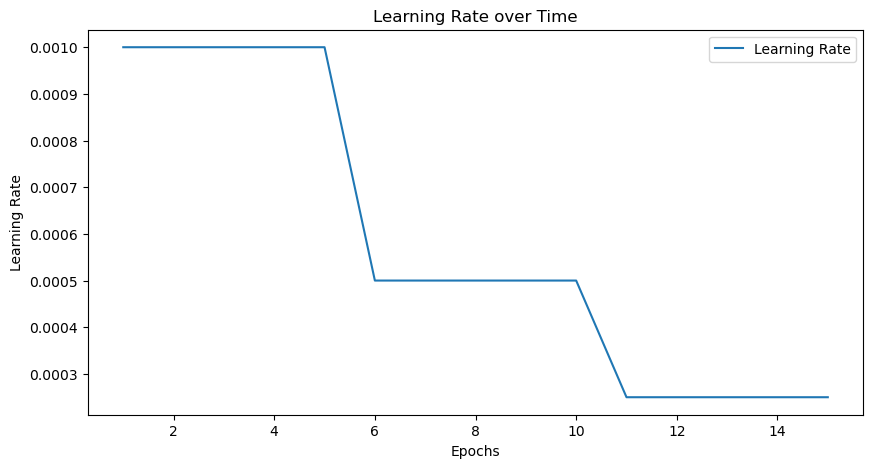

In [55]:
# Save learning rates graph - 1 time run

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), learning_rates, label='Learning Rate')
plt.title('Learning Rate over Time')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig(f'{base_dir}/learning_rate_graph.png')
plt.show()

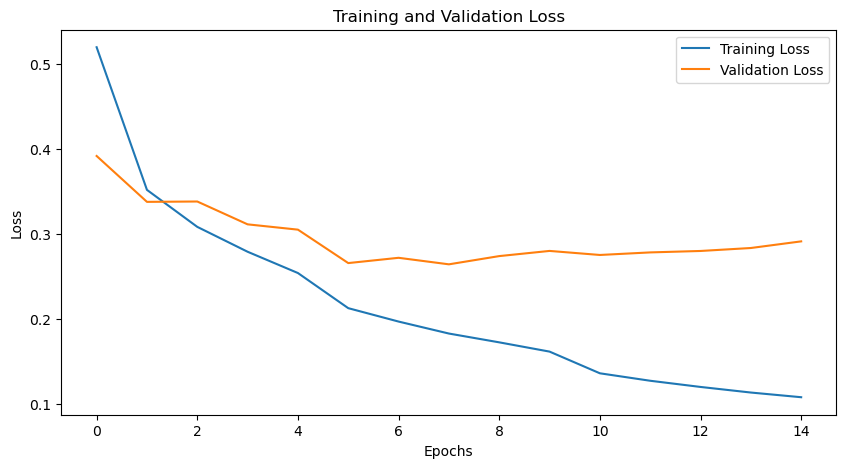

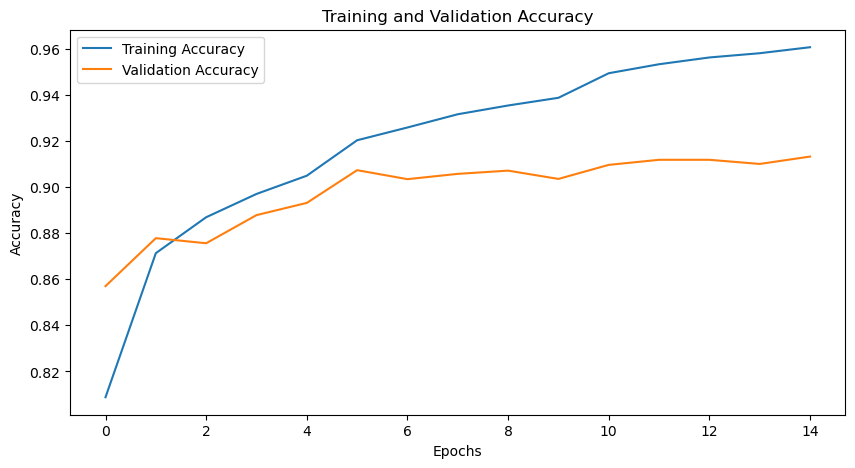

In [33]:
# Store our training and validation loss and accuracy
# Store the image of the training and validation loss and accuracy
# Store the model weights

metrics = {
    'train_losses': train_losses,
    'valid_losses': val_losses,
    'train_accuracies': train_acc,
    'valid_accuracies': val_acc
}

metrics_path = os.path.join(model_dir, 'metrics.json')

with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

# Plotting of the training and validation loss and accuracy

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save graph
plt.savefig(os.path.join(model_dir, 'loss_graph.png'))
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Save graph
plt.savefig(os.path.join(model_dir, 'accuracy_graph.png'))
plt.show()

# Save model weights
model_weights_path = os.path.join(model_dir, 'model_weights.pth')

torch.save(model.state_dict(), model_weights_path)

Epoch 1/15, Train Loss: 0.5152, Train Accuracy: 0.8089
Epoch 2/15, Train Loss: 0.3612, Train Accuracy: 0.8675
Epoch 3/15, Train Loss: 0.3176, Train Accuracy: 0.8831
Epoch 4/15, Train Loss: 0.2887, Train Accuracy: 0.8930
Epoch 5/15, Train Loss: 0.2678, Train Accuracy: 0.9014
Epoch 6/15, Train Loss: 0.2305, Train Accuracy: 0.9152
Epoch 7/15, Train Loss: 0.2178, Train Accuracy: 0.9192
Epoch 8/15, Train Loss: 0.2082, Train Accuracy: 0.9218
Epoch 9/15, Train Loss: 0.2000, Train Accuracy: 0.9248
Epoch 10/15, Train Loss: 0.1917, Train Accuracy: 0.9272
Epoch 11/15, Train Loss: 0.1705, Train Accuracy: 0.9361
Epoch 12/15, Train Loss: 0.1640, Train Accuracy: 0.9385
Epoch 13/15, Train Loss: 0.1590, Train Accuracy: 0.9404
Epoch 14/15, Train Loss: 0.1538, Train Accuracy: 0.9423
Epoch 15/15, Train Loss: 0.1493, Train Accuracy: 0.9444
Test Loss: 0.2818, Test Accuracy: 0.9051
Distribution of True Labels: Counter({4: 1000, 9: 1000, 2: 1000, 6: 1000, 3: 1000, 0: 1000, 8: 1000, 1: 1000, 5: 1000, 7: 1000})

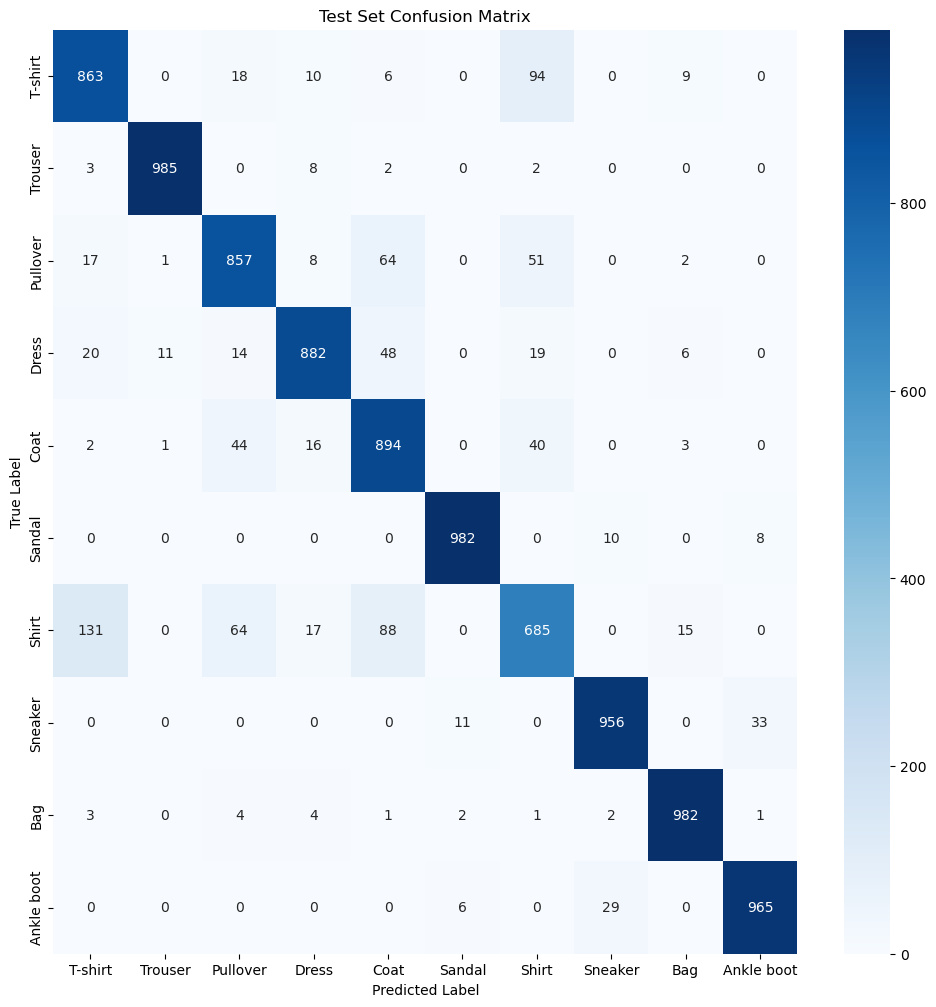

In [7]:
# Task 5 - Test best model on testing data

# Important to make sure that I train this model
# on the full training data (training + validation)

batch_size = 32
num_classes = 10
learning_rate = 0.001

num_epochs = 15

full_training_loader = DataLoader(full_training_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
testing_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)

### Change this to the best model ###
model = LeNet5_Baseline().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
# Learning rate scheduler
# Decrease LR by 1/2 every 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in full_training_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Logging for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss / total_train:.4f}, '
          f'Train Accuracy: {correct_train / total_train:.4f}')
    
    # Step scheduler
    scheduler.step()

from collections import Counter

model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0

all_labels = []
all_preds = []

with torch.no_grad():  # No gradients needed for testing
    for images, labels in testing_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)

        # doesn't work otherwise
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_loss_avg = test_loss / total_test
test_accuracy_avg = correct_test / total_test

print(f'Test Loss: {test_loss_avg:.4f}, '
      f'Test Accuracy: {test_accuracy_avg:.4f}')

base_dir = 'results'

# Save the test metrics
test_metrics = {
    'test_loss': test_loss_avg,
    'test_accuracy': test_accuracy_avg
}
with open(f'{base_dir}/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Distribution of True Labels:", Counter(all_labels))
print("Distribution of Predicted Labels:", Counter(all_preds))

plt.figure(figsize=(12, 12))
# There's a bug here where the numbers are not shown besides first row
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Set Confusion Matrix')
plt.savefig(f'{base_dir}/testset_confusion_matrix.png')
plt.show()

In [61]:
# Need to compare the accuracy and loss of test set with the validation set of the same model

# Save model weights
model_weights_path = os.path.join(base_dir, 'test_model_weights.pth')

torch.save(model.state_dict(), model_weights_path)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.508672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.445572
[t-SNE] KL divergence after 300 iterations: 2.478178


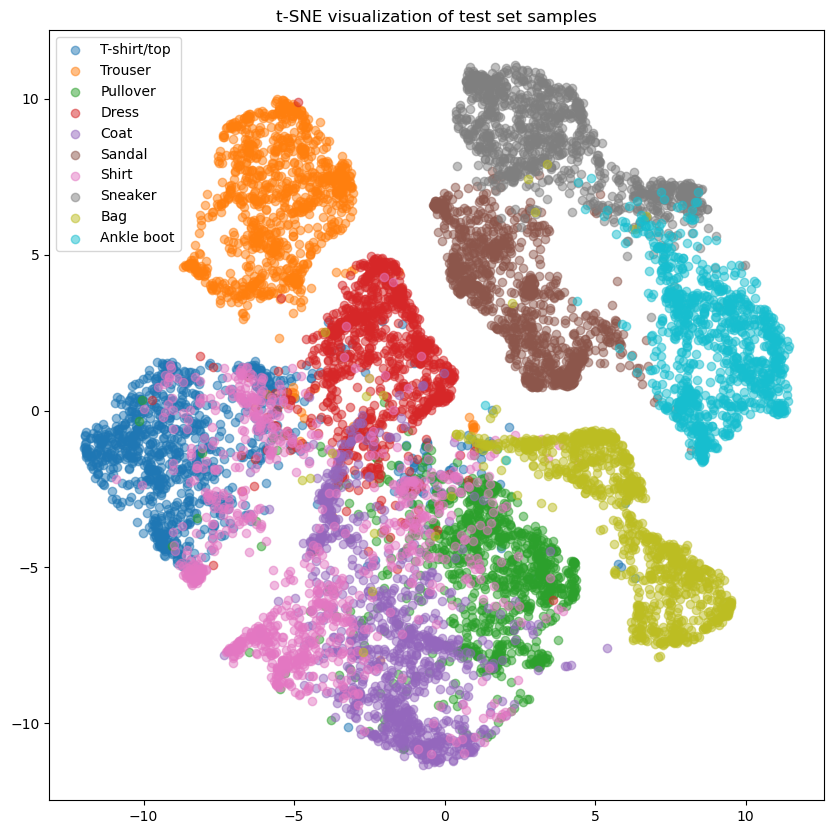

In [65]:
# Choice task for t-SNE visualization

from sklearn.manifold import TSNE
import numpy as np

# THIS NEEDS TO BE CHANGED FROM BASELINE TO USE THE BEST MODEL

class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

class LeNet5_tSNE(torch.nn.Module):
    def __init__(self, base_model=None):
        super(LeNet5_tSNE, self).__init__()
        if base_model is None:
            # If no base model is provided, instantiate a new one.
            base_model = LeNet5_Baseline()
        
        # Directly use layers from the other model.
        self.conv1 = base_model.conv1
        self.conv2 = base_model.conv2
        self.fc1 = base_model.fc1
        self.fc2 = base_model.fc2
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

trained_baseline_model = LeNet5_Baseline().to(device)
trained_baseline_model.load_state_dict(torch.load(f'{base_dir}/test_model_weights.pth'))

feature_model = LeNet5_tSNE(trained_baseline_model).to(device)
feature_model.eval()  # Set it to evaluation mode

# Extract features
features = []
labels_list = []
with torch.no_grad():
    for images, labels in testing_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = feature_model(images)
        features.extend(output.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert to numpy array otherwise we get error at fit_transform
features_array = np.array(features)

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features_array)

# Plot the results
plt.figure(figsize=(10, 10))
for label in np.unique(labels_list):
    # Get indices for each label/class
    indices = [i for i, l in enumerate(labels_list) if l == label]
    # Get the corresponding t-SNE results
    current_tsne = tsne_results[indices]
    # Replace 'label' with 'class_names[label]' to use the class names
    plt.scatter(current_tsne[:, 0], current_tsne[:, 1], label=class_names[label], alpha=0.5)

plt.title('t-SNE visualization of test set samples')
plt.legend()
plt.savefig(f'{base_dir}/tSNE-visualization.png')
plt.show()